In [39]:
import pandas as pd
from tensorflow.keras.saving import load_model
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Some parameters

In [21]:
test_day = 0 # must be an element in [0, 1, 2, 3]
ticker = "ADSK"

## Helper functions copied from src/models/lstm.py

In [22]:
def get_dates_for_training_scheme(df: pd.DataFrame):
    """
    This function returns all dates needed to train, validate and test the model. The training
    follows a rolling window type scheme. The data is trained on 4 days and validated on the 5th. 
    Some portion of the end of the dates are used for testing.

    Args:
        df (pd.DataFrame): dataframe with data.

    Returns:
        List[Tuples]: a list of tuples conatining the training and validation/test dates.
    """
    dates = df["sip_timestamp"].dt.day.unique()

    date_set = []

    num_days_training = 9
    num_days_val_test = 1

    for i in range(0, len(dates) - num_days_training, num_days_val_test):
        date_set.append((dates[i: i + num_days_training], dates[i + num_days_training: i + num_days_training + num_days_val_test]))

    return date_set

def train_val_test(df: pd.DataFrame, days: tuple[np.ndarray, np.ndarray]):
    """
    Splits a dataframe into training and val/test. The splitting is done by given dates.

    Args:
        df (pd.DataFrame): dataframe to split into training and test.
        days (tuple[np.ndarray, np.ndarray]): a tuple containing two arrays of train days and val/test days respectively

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: a train and val/test set of the original dataframe
    """
    
    train = df[df["sip_timestamp"].dt.day.isin(days[0])]
    val_test = df[df["sip_timestamp"].dt.day.isin(days[1])]

    return train, val_test

def create_sequences(data: np.ndarray, seq_length: int):
    """
    Convert DataFrame into sequences of specified length for LSTM input.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, :])  # all columns, including the last one, as features
        y.append(data[i + seq_length, -1])  # last column's lagged value as target

    return np.array(x), np.array(y)

def create_sequences_modified(data, seq_length):
    """
    Convert DataFrame into sequences of specified length for LSTM input. Makes sure sequences do not 
    contain data from different dates.

    Args: 
        data (np.array): complete data containing both x and y
        seq_length (int): the length of the sequence considered in the lstm.

    Returns:
        (np.array, np.array): x and y datasets with the sequences. 
    """
    X, y = [], []
    for date, group_data in data.groupby("date"):
        group_data = group_data.drop(columns=["date"]).values
        X_date, y_date = create_sequences(group_data, seq_length)
        X.append(X_date)
        y.append(y_date)
    return np.concatenate(X), np.concatenate(y)

In [23]:
def get_best_config(ticker: str):
    config_loss_df = pd.read_csv("../../reports/config_space_loss.csv")
    config_loss_df = config_loss_df[config_loss_df["ticker"] == ticker]
    
    id_min_loss = config_loss_df["mse"].idxmin()
    config = config_loss_df.iloc[id_min_loss,:]
    config = config.drop(index = ["ticker", "mse"])
    config = config.to_dict()
    return config


## Loading data and creating model

In [ ]:
df = pd.read_csv("../../data/processed/tq_data_gridded/df_tot_gridded.csv")

In [76]:
ticker_data = df[df["ticker"] == ticker].copy()
ticker_data["sip_timestamp"] = pd.to_datetime(ticker_data["sip_timestamp"])
ticker_data["date"] = ticker_data["sip_timestamp"].dt.date

In [81]:
config = get_best_config(ticker)
date_scheme = get_dates_for_training_scheme(ticker_data)

num_days_testing = 4
date_scheme_test = date_scheme[-num_days_testing:]
date_set = date_scheme_test[test_day]

train, test = train_val_test(ticker_data, date_set)
scaler = StandardScaler()

ts = test["sip_timestamp"].iloc[config["seq_length"]:]

train = train.drop(columns=["ticker", "sip_timestamp"])
test = test.drop(columns=["ticker", "sip_timestamp"])

train.loc[:, train.columns != "date"] = scaler.fit_transform(train.loc[:, train.columns != "date"])
test.loc[:, test.columns != "date"] = scaler.transform(test.loc[:, test.columns != "date"])

X_train, y_train = create_sequences_modified(train, config["seq_length"])
X_test, y_test = create_sequences_modified(test, config["seq_length"])

model = load_model(f"../../reports/models/{ticker}-{test_day}.keras")

y_pred = model.predict(X_test).flatten()

731/731 ━━━━━━━━━━━━━━━━━━━━ 1s 609us/step


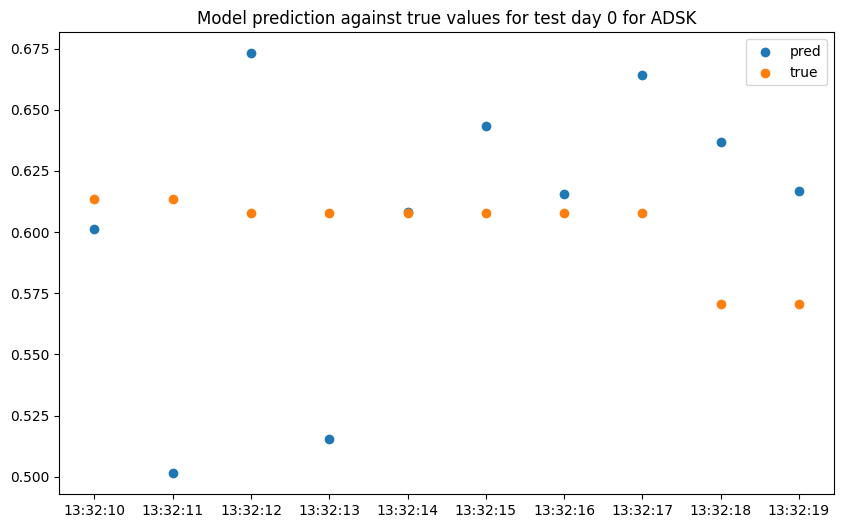

In [99]:
subset = slice(120, 130)

plt.figure(figsize=(10, 6))
plt.scatter(ts.iloc[subset], y_pred[subset], label="pred")
plt.scatter(ts.iloc[subset], y_test[subset], label="true")
plt.legend()
plt.title(f"Model prediction against true values for test day {test_day} for {ticker}")
plt.show()